In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from scipy.stats import norm
from scipy.stats import multivariate_normal
from numpy.linalg import inv

# Q4 - A first Gibbs sampler

## Point 1

In [2]:
# Sample from distribution p(s1,s2|t,y) 
def sample_s(x_b, mu_a, A, b, sigma_a, sigma_ba):
    
    # Calculate Sigma_{a|b}
    sigma_ab = inv(inv(sigma_a) + A.T@inv(sigma_ba)@A)
    
    # Calculate mu_{a|b}
    mu_ab = sigma_ab@(inv(sigma_a)@mu_a + A.T@inv(sigma_ba)@(x_b-b))
    
    # Return N(mu_{a|b}, Sigma_{a|b})
    return multivariate_normal.rvs(mu_ab.reshape(-1), sigma_ab)

# Sample from distribution p(t|s1,s2,y). 
def sample_t(y, s1, s2, sigma_ba):
    
    mean = s1 - s2
    
    # Do moment-matching
    if y == 1:
        a, b = 0, np.Inf
    else:
        a, b = np.NINF , 0
    
    # Scale a, b
    a_scaled, b_scaled = (a - mean) / np.sqrt(sigma_ba), (b - mean) / np.sqrt(sigma_ba)
    
    # Return truncated norm (result from Q3 - 2)
    return truncnorm.rvs(a_scaled, b_scaled, mean, sigma_ba)

# Gibbs sampler
def gibbs(y, mu_a, A, b, sigma_a, sigma_ba, n_samples, burn, s_init):
    s1_samples = np.zeros(n_samples)
    s2_samples = np.zeros(n_samples)
    s1_samples[0] = s_init[0]
    s2_samples[0] = s_init[1]
    for i in range(1, n_samples):
        t = sample_t(y, s1_samples[i-1], s2_samples[i-1], sigma_ba)
        s1_samples[i], s2_samples[i] = sample_s(t, mu_a, A, b, sigma_a, sigma_ba)
    return s1_samples[burn:], s2_samples[burn:]

In [3]:
# Set values
mu_a = np.array([[1, 1]]).T
A = np.array([[1,-1]])
b = np.array([[0]])
sigma_a = np.array([[1,0],[0,1]])
sigma_ba = np.array([[1]])
y = 1

### First run

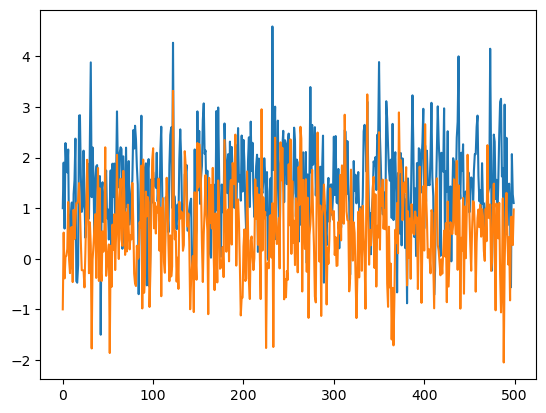

1.44305045823883
0.5514706512501523


In [4]:
n_samples = 500
s_init = [1,-1]
burn = 0
s1, s2 = gibbs(y, mu_a, A, b, sigma_a, sigma_ba, n_samples, burn, s_init)
plt.plot(s1)
plt.plot(s2)
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

print(np.mean(s1))
print(np.mean(s2))

### Analyze burn-in

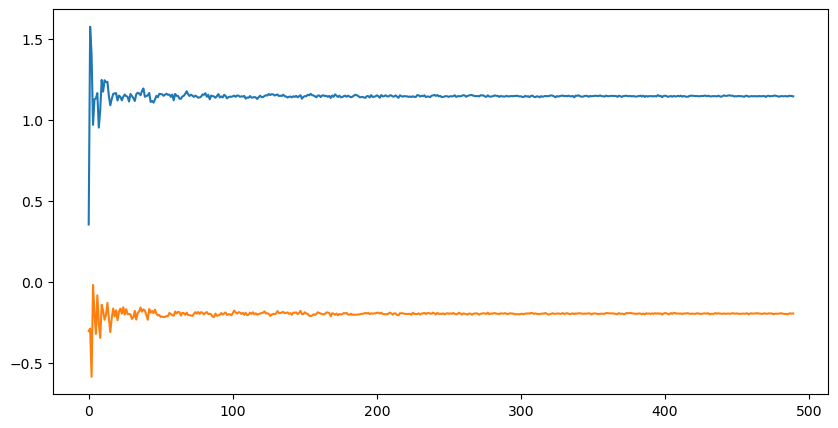

In [12]:
def getMeans(samples):
    for i in range(0, len(samples)):
        samples[i] = np.sum(samples[:i+1])/(i+1)
    return samples

s1_means = getMeans(s1)
s2_means = getMeans(s2)
plt.plot(s1_means)
plt.plot(s2_means)
plt.show()

### Second run

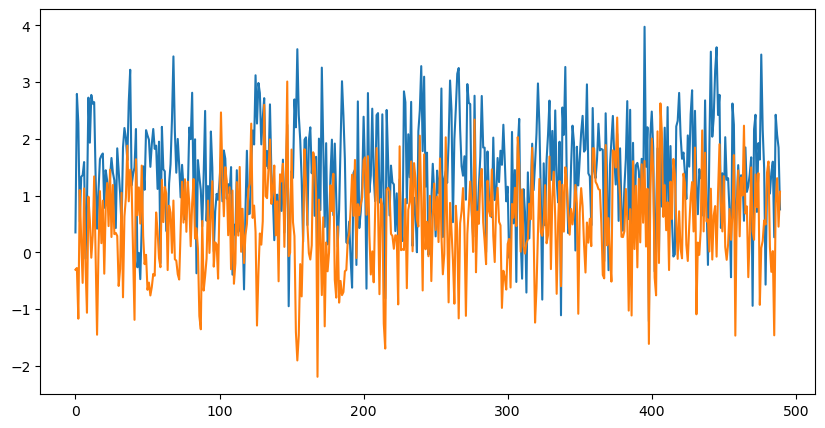

1.4013843970534086
0.5059529260254159


In [7]:
burn = 10
s1, s2 = gibbs(y, mu_a, A, b, sigma_a, sigma_ba, n_samples, burn, s_init)
plt.plot(s1)
plt.plot(s2)
plt.show()

print(np.mean(s1))
print(np.mean(s2))

## Second point 

In [8]:
# Take samples from gibbs sampler and transform into gaussian distributions
def gauss_transform(samples, xs):
    s_mean = np.mean(samples)
    s_cov = np.cov(samples)
    gaussian = multivariate_normal.pdf(xs, s_mean, s_cov, n_samples)
    return gaussian

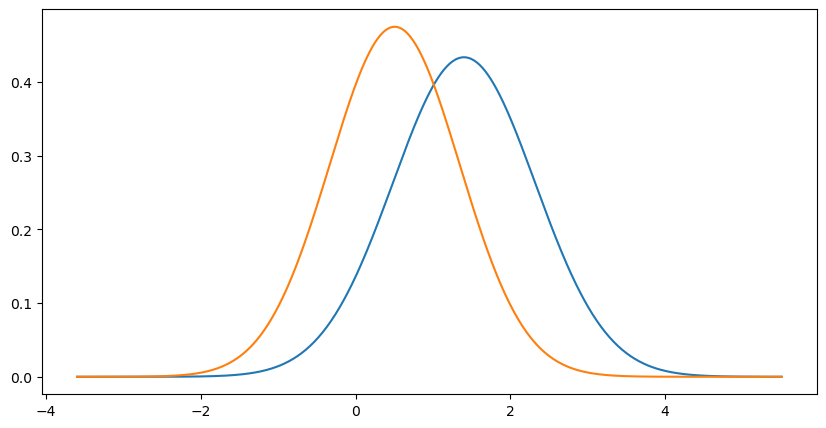

In [9]:
xs = np.linspace(np.mean(s1)-5, np.mean(s2)+5, n_samples)
s1_gauss = gauss_transform(s1, xs)
s2_gauss = gauss_transform(s2, xs)

plt.plot(xs, s1_gauss)
plt.plot(xs, s2_gauss)
plt.show()

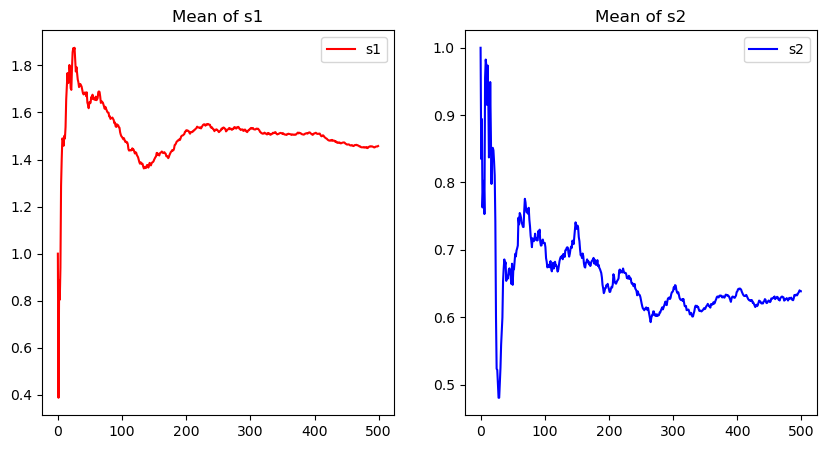

In [10]:
def gibbs_sampler(mu_1, sigma_1, mu_2, sigma_2, sigma_ts, samples):
    # Gibbs Sampling
    if samples < 100:
        print('Too few samples. Samples must be larger than 100\n')
        return

    t = np.zeros(samples)
    s_1 = np.zeros(samples)
    s_2 = np.zeros(samples)

    # Initial values
    s_1[0] = mu_1
    s_2[0] = mu_2
    t[0] = 0

    # Intervals for truncnorm
    myclip_a = 0
    myclip_b = 1000
    my_mean = mu_1 - mu_2
    my_std = sigma_ts
    
    # Matrix
    A = np.array([[1, -1]])
    mu = np.array([[mu_1], [mu_2]])
    sigma_matrix1 = np.array([[sigma_1**2, 0], [0, sigma_2**2]])
    sigma_matrix2 = np.linalg.inv(np.linalg.inv(sigma_matrix1)+np.transpose(A)*(1/sigma_ts**2)@A)

    for i in range(samples-1):
        mu_ts = sigma_matrix2@(np.linalg.inv(sigma_matrix1)@mu+np.transpose(A)*(t[i]/sigma_ts**2))
        mu_ts = np.ravel(mu_ts)
        s_1[i+1], s_2[i+1] = np.random.multivariate_normal(mu_ts, sigma_matrix2)
        my_mean = s_1[i+1] - s_2[i+1]
        a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
        t[i+1] = truncnorm.rvs(a, b, my_mean, my_std)

    # Removing burn-in
    s_1 = s_1[200:]
    s_2 = s_2[200:]

    return s_1, s_2

def gibbs_sampler_burnin(mu_1, sigma_1, mu_2, sigma_2, sigma_ts, samples):
    # Gibbs Sampling
    if samples < 100:
        print('Too few samples. Samples must be larger than 100\n')
        return

    t = np.zeros(samples)
    s_1 = np.zeros(samples)
    s_2 = np.zeros(samples)

    s_1[0] = mu_1
    s_2[0] = mu_2
    t[0] = 0

    s_1mean = np.empty(samples)
    s_2mean = np.empty(samples)
    s_1mean[0] = mu_1
    s_2mean[0] = mu_2
    
    # Intervals for truncnorm
    myclip_a = 0
    myclip_b = 1000
    my_mean = mu_1 - mu_2
    my_std = sigma_ts
    
    # Matrix
    A = np.array([[1, -1]])
    mu = np.array([[mu_1], [mu_2]])
    sigma_matrix1 = np.array([[sigma_1**2, 0], [0, sigma_2**2]])
    sigma_matrix2 = np.linalg.inv(np.linalg.inv(sigma_matrix1)+np.transpose(A)*(1/sigma_ts**2)@A)

    for i in range(samples-1):
        mu_ts = sigma_matrix2@(np.linalg.inv(sigma_matrix1)@mu+np.transpose(A)*(t[i]/sigma_ts**2))
        mu_ts = np.ravel(mu_ts)
        s_1[i+1], s_2[i+1] = np.random.multivariate_normal(mu_ts, sigma_matrix2)
        my_mean = s_1[i+1] - s_2[i+1]
        a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
        t[i+1] = truncnorm.rvs(a, b, my_mean, my_std)
        s_1mean[i+1] = np.sum(s_1)/(i+2)
        s_2mean[i+1] = np.sum(s_2)/(i+2)
        
    return s_1mean, s_2mean

def output_values_1(s_1, s_2):
    # Initial values
    # mu = 1
    # sigma = 1
    mu = 1 
    sigma = 1
    #x = np.linspace(mu-5*sigma,mu+5*sigma,100)

    # Calculate mean and standard deviation
    mu_s1 = np.mean(s_1)
    std_s1 = np.std(s_1)
    S1 = norm.pdf(x, mu_s1, std_s1)
    mu_s2 = np.mean(s_2)
    std_s2 = np.std(s_2)
    S2 = norm.pdf(x, mu_s2, std_s2)
    return mu_s1, std_s1, S1, mu_s2, std_s2, S2

def output_values_2(s_1, s_2):
    # Initial values
    # mu = 1
    # sigma = 1
    mu = 25 
    sigma = 25/3
    #x = np.linspace(mu-5*sigma,mu+5*sigma,100)

    # Calculate mean and standard deviation
    mu_s1 = np.mean(s_1)
    std_s1 = np.std(s_1)
    S1 = norm.pdf(x, mu_s1, std_s1)
    mu_s2 = np.mean(s_2)
    std_s2 = np.std(s_2)
    S2 = norm.pdf(x, mu_s2, std_s2)
    return mu_s1, std_s1, S1, mu_s2, std_s2, S2

def predict(mu_1, sigma_1, mu_2, sigma_2, samples):
    # Generate samples
    s_1 = np.random.normal(mu_1, sigma_1, samples)
    s_2 = np.random.normal(mu_2, sigma_2, samples)

    # Check score
    t = np.mean(s_1 - s_2)
    y = np.sign(t)
    return(y)

def prediction_accuracy(prediction, data):
    results = []
    count = 0
    score = data['score1'] - data['score2']
    # Calculating y for the actual scores
    for i in range(data.shape[0]):
        if score[i] > 0:
            results.append(1)
        elif score[i] < 0:
            results.append(-1)
        else:
            results.append(0)

    # Comparing with our predictions
    for k in range(len(results)):
        if results[k] == prediction[k]:
            count += 1

    draws = results.count(0)
    accuracy = count/len(results)
    accuracy_no_draws = count/(len(results)-draws)
    # Printing out results
    print("Number of correct predictions:", count)
    print("Prediction accuracy: "+ str(round((accuracy*100),2)) + "%")
    print("Prediction accuracy if draws are disregarded:" + str(round((accuracy_no_draws*100),2)) + "%")
    
def multiplyGauss(mu_1, sigma_1, mu_2, sigma_2):
    # Given function from session 9
    sigma = 1/(1/sigma_1+1/sigma_2)
    mu = (mu_1/sigma_1+mu_2/sigma_2)*sigma
    return mu, sigma 

def divideGauss(mu_1, sigma_1, mu_2, sigma_2):
    # Given function from session 9
    mu, sigma = multiplyGauss(mu_1, sigma_1, mu_2, -sigma_2)
    return mu, sigma   

def truncGaussMM(my_a, my_b, mu_1, sigma_1):
    # Given function from session 9
    a, b = (my_a - mu_1) / np.sqrt(sigma_1), (my_b - mu_1) / np.sqrt(sigma_1)
    mu = truncnorm.mean(a, b, loc=mu_1, scale=np.sqrt(sigma_1))
    sigma = truncnorm.var(a, b, loc=0, scale=np.sqrt(sigma_1))
    return mu, sigma
# ----------------------- Q5 part 1 -----------------------
mu_1 = 1
mu_2 = 1
sigma_1 = 1
sigma_2 = 1 
sigma_ts = 1 
samples = 500

s_1, s_2 = gibbs_sampler_burnin(mu_1, sigma_1, mu_2, sigma_2, sigma_ts, samples)

plt.figure(1)
plt.subplot(1, 2, 1)
plt.plot(s_1,label="s1", color='red')
plt.legend(loc='upper right')
plt.title('Mean of s1')
plt.subplot(1, 2, 2)
plt.plot(s_2,label="s2", color='blue')
plt.legend(loc='upper right')
plt.title('Mean of s2')
plt.show()


In [11]:
print(np.mean(s_1))
print(np.mean(s_2))

1.5097070771092653
0.65940507819105
